In [1]:
%load_ext autoreload
%autoreload 2

from notebooks.utils import *
from notebooks.plot_utils import *

In [2]:
from utils.misc import fix_random_seed
fix_random_seed(2)

Training samples: 2000, Testing samples: 300


Epoch 5/5: 100%|██████████| 62/62 [00:00<00:00, 240.23it/s, acc=96.77%, loss=0.156] 


Training Accuracy: 96.00%
[1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Test Accuracy: 33.33%
[1.0, 1.0, 0.0, 0.0, 0.0, 0.0]


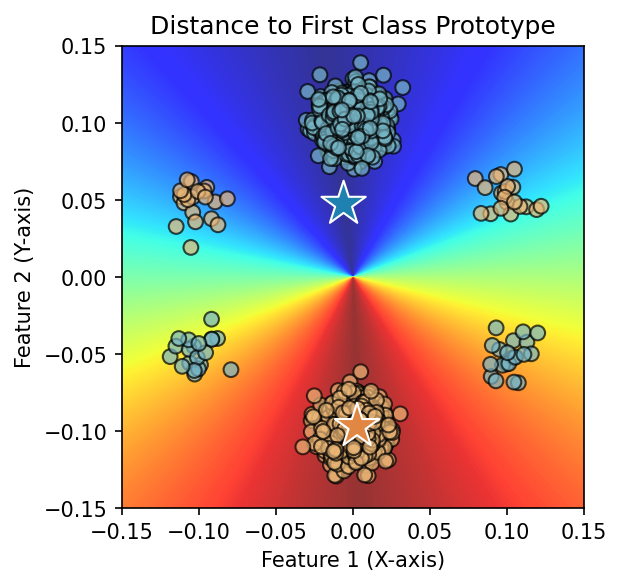

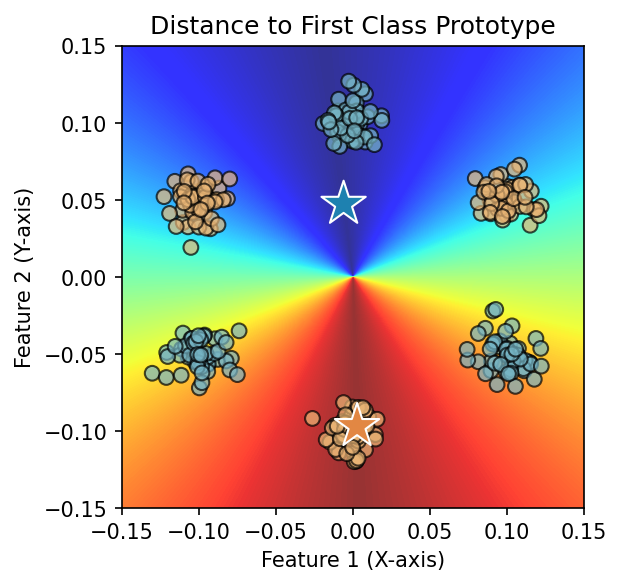

In [3]:
# Step 1: Generate Clusters
X_train, y_train, subgroups_train = generate_clusters(total_samples=2000, random_state=42)
X_test, y_test, subgroups_test = generate_balanced_clusters(total_samples=300, random_state=42)

# Step 4: Normalize Features
# X_train_normed, X_test_normed = normalize_features(X_train, X_test)
X_train_normed, X_test_normed = (X_train, X_test)

# Step 5: Create DataLoaders
training_loader, test_loader, train_size, test_size = create_dataloaders(X_train_normed, y_train, X_test_normed, y_test, batch_size=32)
_, training_eval_loader, *_ = create_dataloaders(X_train_normed, y_train, X_train_normed, y_train, batch_size=32)
print(f"Training samples: {train_size}, Testing samples: {test_size}")

# Step 6: Train the Model
input_dim = X_train_normed.shape[1]
num_classes = 2  # Binary classification
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = train_model(training_loader, test_loader, input_dim, num_classes, device=device, epochs=5, lr=1e-3, entropic_scale=1, optim_name='sgd')

# # -------------------------------
# # Execute the Function
# # -------------------------------
model.eval()
plot_distance_to_first_class(model, X_train_normed, y_train)
plot_distance_to_first_class(model, X_test_normed, y_test)

# Evaluate on Training Set
correct, true_pos = evaluate_model(model, training_eval_loader, device, set_name='Training')

subgroups_train_unique, counts = np.unique(subgroups_train, return_counts=True)
per_group_acc = [(sum(true_pos[subgroups_train==g])/count).item() for g, count in zip(subgroups_train_unique, counts)]
print(per_group_acc)

# Evaluate on Test Set
correct, true_pos = evaluate_model(model, test_loader, device)

subgroups_test_unique, counts = np.unique(subgroups_test, return_counts=True)
per_group_acc = [(sum(true_pos[subgroups_test==g])/count).item() for g, count in zip(subgroups_test_unique, counts)]
print(per_group_acc)

Training samples: 1920, Testing samples: 300


Epoch 4/4: 100%|██████████| 240/240 [00:00<00:00, 272.57it/s, acc=100.00%, loss=0.100]


Test Accuracy: 33.33%
Training samples: 40, Testing samples: 300


Epoch 4/4: 100%|██████████| 5/5 [00:00<00:00, 343.33it/s, acc=100.00%, loss=0.136]


Test Accuracy: 33.33%
Training samples: 40, Testing samples: 300


Epoch 4/4: 100%|██████████| 5/5 [00:00<00:00, 260.77it/s, acc=100.00%, loss=0.158]


Test Accuracy: 33.33%
Training Accuracy: 96.00%
[1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Test Accuracy: 33.33%
[1.0, 1.0, 0.0, 0.0, 0.0, 0.0]

Training Accuracy: 2.00%
[0.0, 0.0, 1.0, 1.0, 0.0, 0.0]
Test Accuracy: 33.33%
[0.0, 0.0, 1.0, 1.0, 0.0, 0.0]

Training Accuracy: 2.00%
[0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
Test Accuracy: 33.33%
[0.0, 0.0, 0.0, 0.0, 1.0, 1.0]



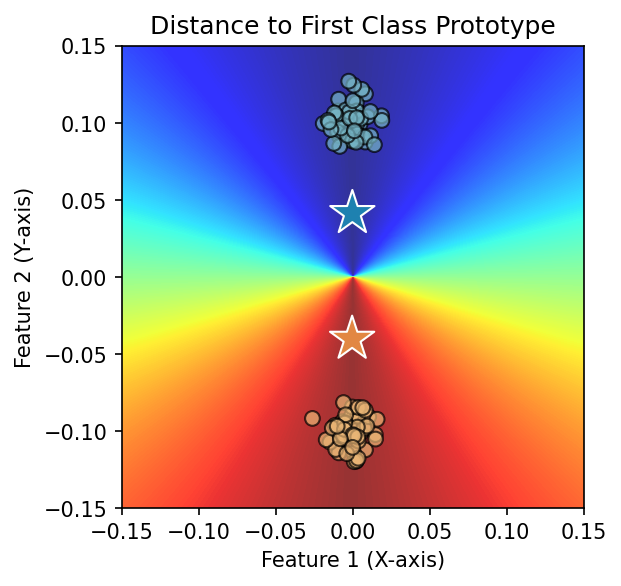

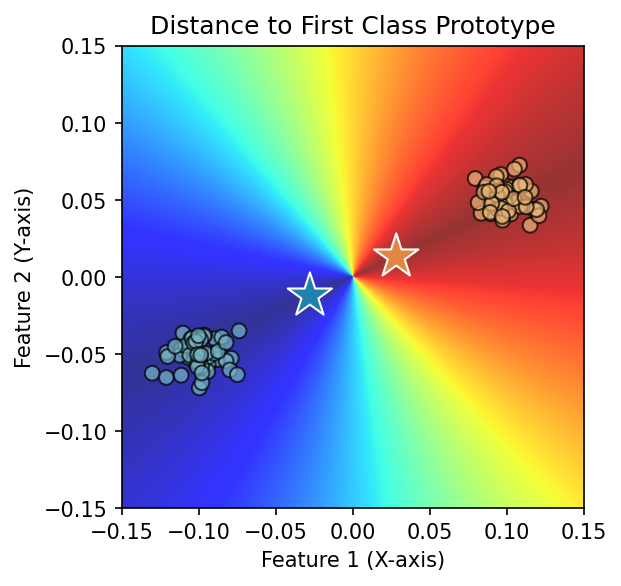

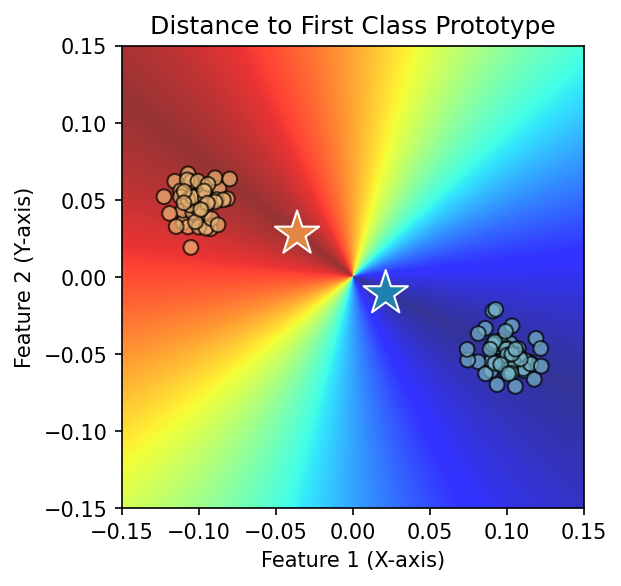

In [4]:
def train_subsampled(condition, condition_test=None):
    # Create DataLoaders on subgroup 2
    training_loader, test_loader, train_size, test_size = create_dataloaders(X_train_normed[condition], y_train[condition],
                                                                             X_test_normed, y_test, batch_size=8)
    _, training_eval_loader, *_ = create_dataloaders(X_train_normed, y_train, X_train_normed, y_train, batch_size=32)
    print(f"Training samples: {train_size}, Testing samples: {test_size}")

    # Train the Model
    input_dim = X_train_normed.shape[1]
    num_classes = 2  # Binary classification
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model = train_model(training_loader, test_loader, input_dim, num_classes, device=device, epochs=4, lr=1e-3, optim_name='sgd',
                        entropic_scale=1)
    evaluate_model(model, test_loader, device)
    prototypes = model.prototypes.detach().cpu().numpy()

    if condition_test is not None:
        model.eval()
        plot_distance_to_first_class(model, X_test_normed[condition_test], y_test[condition_test])
    return model


models = [
    train_subsampled(subgroups_train < 2, subgroups_test < 2),
    train_subsampled((subgroups_train > 1) & (subgroups_train < 4), (subgroups_test > 1) & (subgroups_test < 4)),
    train_subsampled(subgroups_train > 3, subgroups_test > 3)
]

# Evaluate on Training Set
for model in models:
    correct, true_pos = evaluate_model(model, training_eval_loader, device, set_name='Training')

    subgroups_train_unique, counts = np.unique(subgroups_train, return_counts=True)
    per_group_acc = [(sum(true_pos[subgroups_train == g]) / count).item() for g, count in
                     zip(subgroups_train_unique, counts)]
    print(per_group_acc)

    # Evaluate on Test Set
    correct, true_pos = evaluate_model(model, test_loader, device)

    subgroups_test_unique, counts = np.unique(subgroups_test, return_counts=True)
    per_group_acc = [(sum(true_pos[subgroups_test == g]) / count).item() for g, count in zip(subgroups_test_unique, counts)]
    print(per_group_acc)
    print()

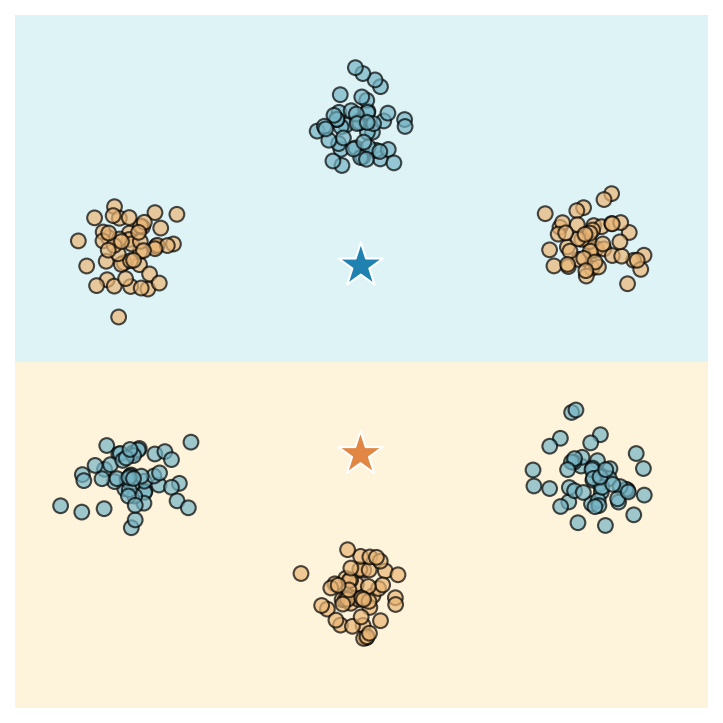

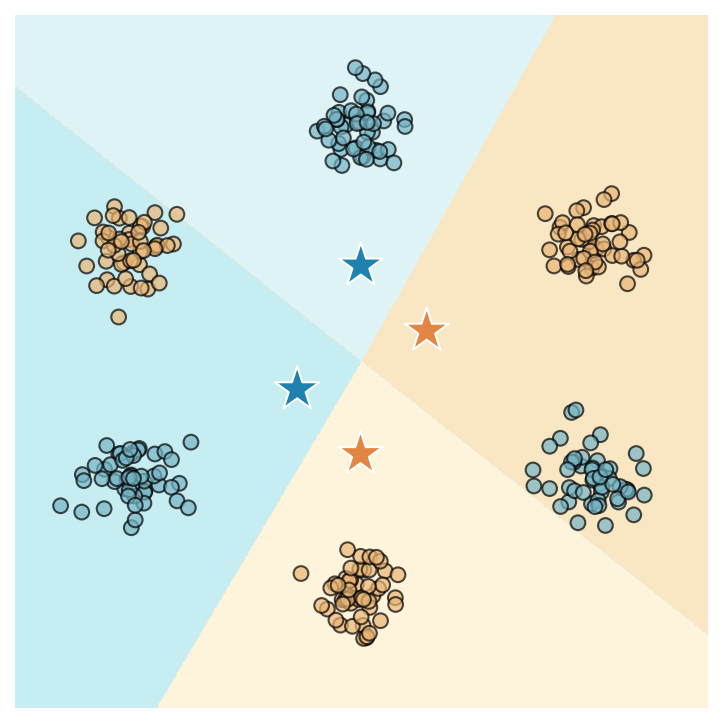

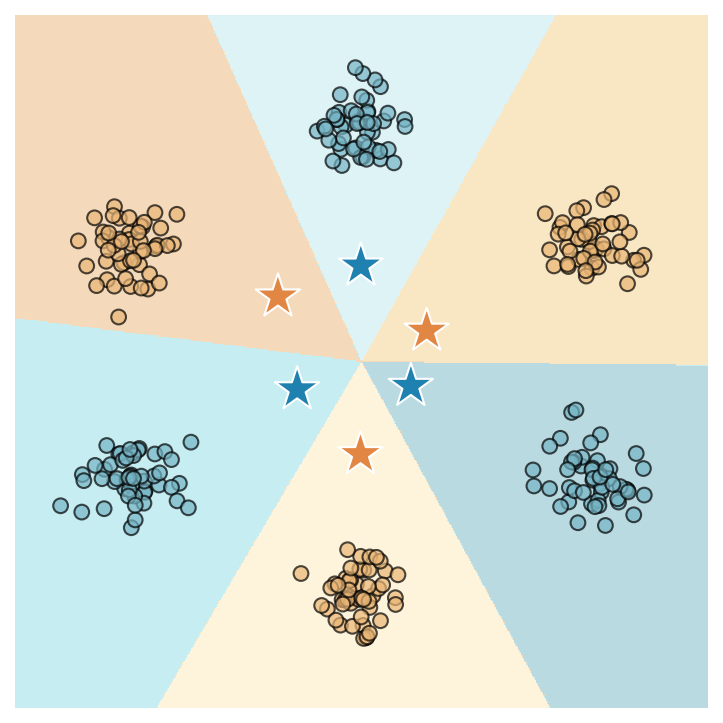

In [5]:
prototypes = torch.concat([_.prototypes.detach().cpu() for _ in models]).numpy().astype('float32')
distance_scales = torch.concat([_.distance_scale.detach().cpu() for _ in models]).float()
distance_scales = distance_scales.repeat((2, 1)).T.flatten()
# plot_voronoi_with_distances(prototypes, distance_scales, X_test_normed, y_test)

plot_distance_to_first_class_v1(prototypes[:2], distance_scales[:2], X_test_normed, y_test)
plot_distance_to_first_class_v1(prototypes[:4], distance_scales[:4], X_test_normed, y_test)
plot_distance_to_first_class_v1(prototypes, distance_scales, X_test_normed, y_test)

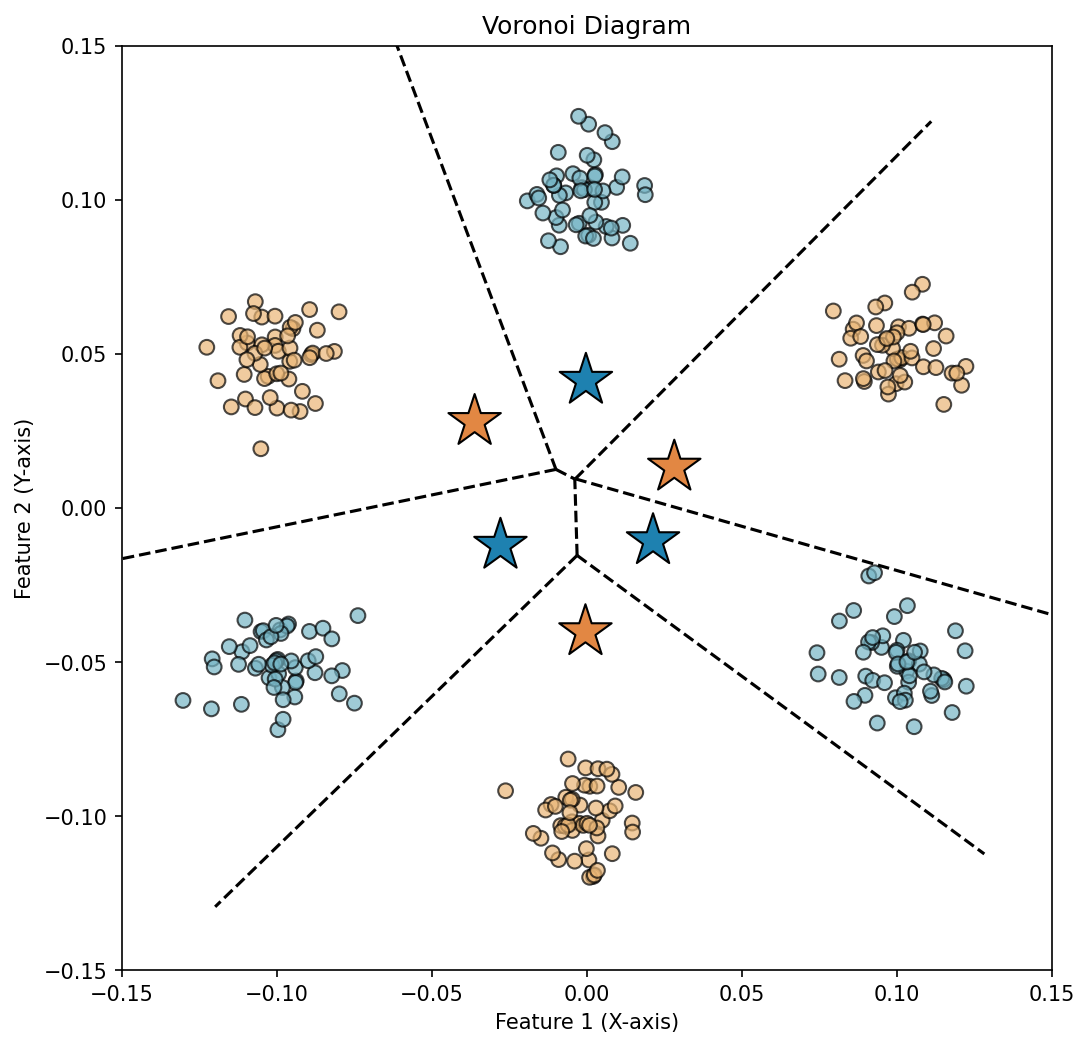

In [6]:
prototypes = torch.concat([_.prototypes.detach().cpu() for _ in models]).numpy().astype('float32')
distance_scales = torch.concat([_.distance_scale.detach().cpu() for _ in models]).float()
distance_scales = distance_scales.repeat((2, 1)).T.flatten()

plot_voronoi_with_distances(prototypes, distance_scales, X_test_normed, y_test)

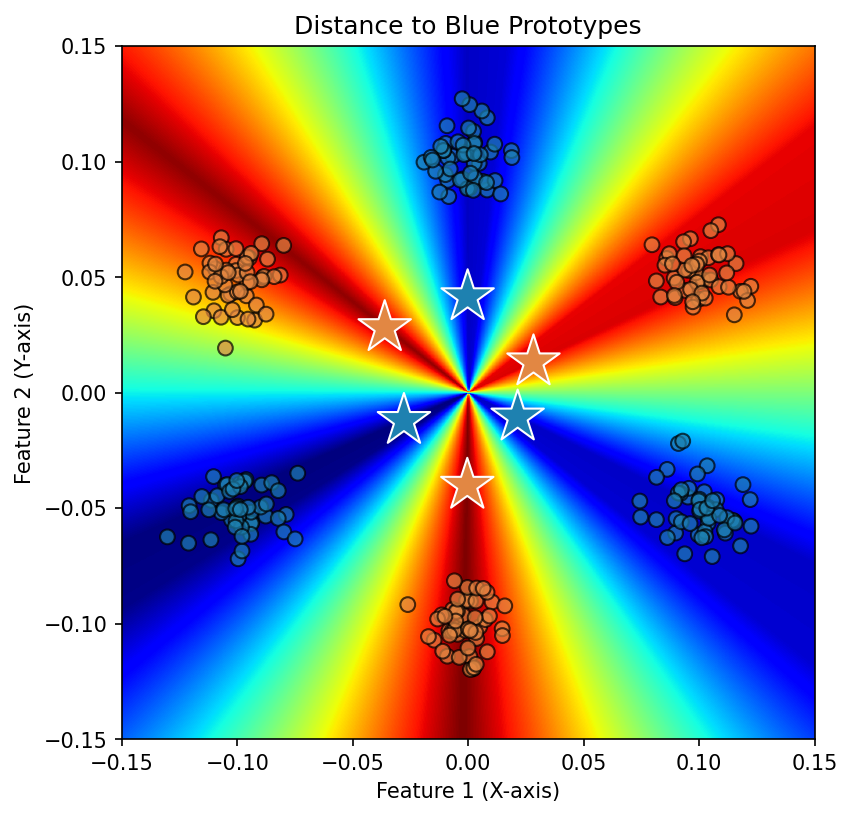

In [7]:
prototypes = torch.concat([_.prototypes.detach().cpu() for _ in models]).numpy().astype('float32')
distance_scales = torch.concat([_.distance_scale.detach().cpu() for _ in models]).float()
distance_scales = distance_scales.repeat((2, 1)).T.flatten()

plot_distance_to_first_class_v2(prototypes, distance_scales, X_test_normed, y_test)